<a href="https://colab.research.google.com/github/Mikaner/reinforcement/blob/main/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get -qq -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1 > /dev/null
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!apt -qq install xvfb freeglut3-dev ffmpeg> /dev/null
!pip -q install gym
!pip -q install JSAnimation
!pip -q install pyglet
!pip -q install pyopengl
!pip -q install pyvirtualdisplay

E: Unable to locate package libcusparse8.0
E: Couldn't find any package by glob 'libcusparse8.0'
E: Couldn't find any package by regex 'libcusparse8.0'
E: Unable to locate package libnvrtc8.0
E: Couldn't find any package by glob 'libnvrtc8.0'
E: Couldn't find any package by regex 'libnvrtc8.0'




In [2]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = f":{display.display}"
# https://github.com/ponty/PyVirtualDisplay/issues/54

In [3]:
# 動画の描画関数の宣言
# 参考URL: http://nbviewer.jupyter.org/github/patrickmineault/xcorr-notebooks/blob/master/Render%20OpenAI%20gym%20as%20GIF.ipynb
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
#from IPython.display import display
from IPython.display import HTML

def make_anim(frames):
    plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), 
               dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])
    
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames),
                                   interval=50)
    return anim

def save_frames_as_gif(frames):
    """
    DISPLAYs a list of frames as a gif, with controls
    """
    
    anim = make_anim(frames)
    anim.save('movie_cartpole_DQN.mp4')
    #display(display_animation(anim, default_mode='loop'))
    return anim.to_jshtml()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym

In [5]:
# namedtupleの実装
# namedtupleにて値とフィールド名をペアで格納できる
# 以下は使用例

from collections import namedtuple

Tr = namedtuple('tr', ('name_a', 'value_b'))
Tr_object = Tr('名前Aです', 100)

print(Tr_object)
print(Tr_object.value_b)

tr(name_a='名前Aです', value_b=100)
100


In [6]:
# namedtupleを生成
from collections import namedtuple

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [7]:
ENV = 'CartPole-v0'
GAMMA = 0.99
MAX_STEPS = 200
NUM_EPISODES = 500

In [8]:
# ミニバッチ学習を実現するために
# 経験を保存するメモリクラスを定義します

class ReplayMemory:
    def __init__(self, CAPACITY):
        self.capacity = CAPACITY
        self.memory = []
        self.index = 0

    def push(self, state, action, state_next, reward):
        '''transition = (state, action, state_next, reward)をメモリに保存する'''

        if len(self.memory) < self.capacity:
            self.memory.append(None) # メモリが満タンでないときは足す
            
        # namedtupleのTransitionを使用し、値とフィールド名をペアにして保存します
        self.memory[self.index] = Transition(state, action, state_next, reward)

        self.index = (self.index + 1) % self.capacity # 保存するindexを1つずらす(最大の場合は最初に上書き)

    def sample(self, batch_size):
        '''batch_size分だけ、ランダムに保存内容を取り出す'''
        return random.sample(self.memory, batch_size)

    def __len__(self):
        '''関数lenに対して、現在の変数memoryの長さを返す'''
        return len(self.memory)

In [42]:
# エージェントが持つ脳となるクラス。DQNを実行する。
# Q関数をディープラーニングのネットワークをクラスとして定義

import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

BATCH_SIZE = 32
CAPACITY = 10000  # メモリの最大値(メモリが足りなくなるなんてことがあるのかしら)

class Brain:
    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions # CartPoleの行動(右に左に押す)の2を取得

        # 経験を記憶するメモリオブジェクトを生成
        self.memory = ReplayMemory(CAPACITY)
        
        # ニューラルネットワークを構築
        self.model = nn.Sequential()
        self.model.add_module('fc1', nn.Linear(num_states, 32))
        self.model.add_module('relu1', nn.ReLU())
        self.model.add_module('fc2', nn.Linear(32, 32))
        self.model.add_module('relu2', nn.ReLU())
        self.model.add_module('fc3', nn.Linear(32, num_actions))

        print(self.model)

        # 最適化手法の設定
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)

    def replay(self):
        '''Experience Replayでネットワークの結合パラメータを学習'''

        # -------------------------------------------------
        # 1. メモリサイズの確認
        # -------------------------------------------------
        # 1.1 メモリサイズがミニバッチより小さい間は何もしない
        if len(self.memory) < BATCH_SIZE:
            return
        
        # -------------------------------------------------
        # 2. ミニバッチの作成
        # -------------------------------------------------
        # 2.1 メモリからミニバッチ分のデータを取り出す
        transitions = self.memory.sample(BATCH_SIZE)

        # 2.2 各変数をミニバッチに対応する形に変形
        # transitionsは1stepごとの(state, action, state_next, reward)が、BATCH_SIZE分格納されている
        # つまり、(state, action, state_next, reward)×BATCH_SIZE
        # これをミニバッチにしたい。つまり
        # (state×BATCH_SIZE, action×BATCH_SIZE, state_next×BATCH_SIZE, reward×BATCH_SIZE)にする
        # ちなみにそれぞれは「各要素の数」を表してそうですね。
        batch = Transition(*zip(*transitions))
        # 例えば、
        # step (state, action, state_next, reward)が
        #    1 (    2,      0,          1,      1)
        #    2 (    1,      1,          2,      0)となっている場合
        # batch内は
        # ([2,1], [0,1], [1,2], [1,0])となっている感じかしら。

        # 2.3 各変数の要素をミニバッチに対応する形に変形する。
        # 例えばstateの場合、[torch.FloatTensor of size 1×4]がBATCH_SIZE分並んでいる(カートの位置、速度、棒の角度、角速度)
        # のですが、それを torch.FloatTensor of size BATCH_SIZE×4に変換します。←要は1をBATCH_SIZE数に変更するということですね
        # catはConcatenates(結合)のことです。
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        # 要はstateが
        # ([[20, 3, 1/2pi, 0.5], [22, 2, 3/4pi, 1]])と並んでいるのを
        # ([[20, 22], [3, 2], [1/2pi, 3/4pi], [0.5, 1]])みたいに変えるって事かな

        # -------------------------------------------------
        # 3. 教師信号となるQ(s_t, a_t)値を求める
        # -------------------------------------------------
        # 3.1 ネットワークを推論モードに切り替える
        self.model.eval()

        # 3.2 ネットワークが出力したQ(s_t, a_t)を求める
        # self.model(state_batch)は、右左の両方のQ値を出力しており
        # [torch.FloatTensor of size BATCH_SIZE×2]になっている
        # ここから実行したアクションa_tに対応するQ値を求めるため、action_batchで行った行動a_tが右か左かのindexを求め
        # それに対応するQ値をgatherで引っ張り出す。 ← gatherで引っ張り出すって具体的な挙動は何をする関数なのだろうか ← おそらくgatherでQ値を引っ張り出すって意味だと思われる。具体的な挙動は下セルに書いた。
        # ようわからんけど、state_batchの時に出力した値からgather使ってどっちを選んでるかを判断するみたいな感じかしら
        # いや、state_batchのデータで推論して、それのアクション(左右)とaction_batchと対応付けているんじゃないかな
        # まあ簡単に言うと、action_batchで判断したインデックスのQ値を求めてるっぽい

        state_action_values = self.model(state_batch).gather(1, action_batch)

        # 3.3 max{Q(s_t+1, a)}値を求める。ただし次の状態があるかに注意

        # cartpoleがdoneになっておらず、next_stateがあるかをチェックするインデックスマスクを作成
        # ここlambda使ったワンライナーの悪行風味
        non_final_mask = torch.ByteTensor(
            tuple(map(lambda s: s is not None, batch.next_state)))
        # まずは全部0にしておく
        next_state_values = torch.zeros(BATCH_SIZE)

        # 次の状態があるindexの最大Q値を求める
        # 出力にアクセスし、max(1)で列方向の最大値の[値、index]を求めます
        # そしてそのQ値(上で取り出した出力[値、index]の0番目)を出力します。
        # detachでその値を取り出します。
        # えっと？つまり？次が存在するもののマックス値を求めてるってことか？
        # いや、正確に言うと、次が存在する状態のQ値の集合(?)のそれぞれの最大を取得しているみたい。
        next_state_values[non_final_mask] = self.model(non_final_next_states).max(1)[0].detach()
        
        # 3.4 教師となるQ(s_t, a_t)値を、Q学習の式から求める (要は誤差を求めるわけですわ)
        expected_state_action_values = reward_batch + GAMMA * next_state_values

        # -------------------------------------------------
        # 4. 結合パラメータの更新
        # -------------------------------------------------
        # 4.1 ネットワークを訓練モードに切り替える
        self.model.train()

        # 4.2 損失関数を計算する (smooth_l1_lossはHuberloss) ← Huberlossとは
        # expected_state_action_valusは
        # sizeが[minibatch]になっているので、unsqueezeで[minibatch × 1]へ
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1)) # この(1)って引数？ 間のスペースいる？

        # 4.3 結合パラメータを更新する
        self.optimizer.zero_grad() # 勾配をリセット ← なんでリセットするんだっけ。前の更新したデータが残ってるからか。
        loss.backward() # バックプロパゲーションを計算
        self.optimizer.step() # 結合パラメータを更新
#        print("update")

    def decide_action(self, state, episode):
        ''' 現在の状況に応じて、行動を決定する '''
        # ε-greedy法で徐々に最適行動のみを採用する
        epsilon = 0.5 * (1 / (episode + 1))

        if epsilon <= np.random.uniform(0, 1):
            self.model.eval() # ネットワークを推論モードに切り替える
            with torch.no_grad():
                action = self.model(state).max(1)[1].view(1, 1)
            # ネットワークの出力の最大値のindexを取り出します = max(1)[1]
            # .view(1, 1)は[torch.LongTensor of size 1] を size 1x1 に変換します
        
        else:
            # 0, 1の行動をランダムに返す
            action = torch.LongTensor([[random.randrange(self.num_actions)]]) # 0, 1の行動をランダムに返す
            # actionは[torch.LongTensor of size 1x1]の形になります

        return action

In [10]:
# torch.gather(input, dim, index)
t = torch.tensor([[0, 1], [2, 3]])
print(torch.gather(t, 1, torch.tensor([[0, 0],[1, 0]])))
# print(t.gather(1, torch.tensor([[0, 0],[1, 0]])))
# dim = 次元 ( 0は行, 1は列 )
# index = その次元のindex。0は0番目
# input = 解析する元のデータ。torch.tensorのインスタンスの場合はインスタンス.gather()でも動く

tensor([[0, 0],
        [3, 2]])


In [43]:
class Agent:
    def __init__(self, num_states, num_actions):
        '''課題の状態と行動の数を設定する'''
        self.brain = Brain(num_states, num_actions)
        # エージェントが行動を決定するための頭脳を生成

    def update_q_function(self):
        '''Q関数を更新'''
        self.brain.replay()

    def get_action(self, state, episode):
        '''行動を決定する'''
        action = self.brain.decide_action(state, episode)
        return action

    def memorize(self, state, action, state_next, reward):
        '''memoryオブジェクトに、state, action, state_next, rewardの内容を保存する'''
        self.brain.memory.push(state, action, state_next, reward)

In [47]:
# 多分ここがバグってる ← 62行目のインデントが間違ってた

class Environment:
    def __init__(self):
        self.env = gym.make(ENV) # 実行する課題を設定
        self.num_states = self.env.observation_space.shape[0]
        # 課題の状態と行動の数を設定
        self.num_actions = self.env.action_space.n # CartPoleの行動（右に左に押す）の2を取得

        # 環境内で行動するAgentを設定
        self.agent = Agent(self.num_states, self.num_actions)

    def run(self):
        '''実行'''
        episode_10_list = np.zeros(10) # 10試行分の立ち続けたstep数を格納し、平均ステップ数を出力に利用

        complete_episodes = 0 # 195ステップ以上連続で立ち続けた試行数
        episode_final = False # 最後の試行フラグ
        frames = [] # 最後の試行を確認する動画用のフレーム

        for episode in range(NUM_EPISODES):
            observation = self.env.reset() # 環境の初期化

            state = observation # 観測をそのまま状態sとして使用
            state = torch.from_numpy(state).type(torch.FloatTensor) # numpy変数をPyTorchのテンソルに変換
            # FloatTensor of size 4をsize 1×4に変換
            state = torch.unsqueeze(state, 0)

            for step in range(MAX_STEPS):
                
                if episode_final or episode==NUM_EPISODES-1: # 最終試行ではframesに各時刻の画像を追加していく
                    frames.append(self.env.render(mode='rgb_array'))

                action = self.agent.get_action(state, episode) # 行動を求める
                #print(action)

                # 行動a_tの実行により、s_{t+1}とdoneフラグを求める
                # actionから.item()を指定して、中身を取り出す
                observation_next, _, done, _ = self.env.step(action.item()) # rewardとinfoは使わないので_

                # 報酬を与える。さらにepisodeの終了評価と、state_nextを設定する
                if done: # ステップ数が200経過するか、一定角度以上傾いた場合
                    state_next = None

                    # 直近10episodeの立てたstep数リストに追加
                    episode_10_list = np.hstack((episode_10_list[1:], step + 1))

                    if step < 195:
                        reward = torch.FloatTensor([-1.0]) # 途中でこけたら罰則として報酬-1を与える
                        complete_episodes = 0 # 連続性高記録をリセット
                    else:
                        reward = torch.FloatTensor([1.0]) # 立ったまま終了時は報酬1を与える

                        complete_episodes += 1
                else:
                    reward = torch.FloatTensor([0.0]) # 普段は報酬0
                    state_next = observation_next # 観測をそのまま状態とする
                    state_next = torch.from_numpy(state_next).type(torch.FloatTensor) # numpy変数をPyTorchのテンソルに変換
                    # FloatTensor of size 4 を size 1×4 に変換 ←ここ何やってんの？テンソルにした意味なに？
                    state_next = torch.unsqueeze(state_next, 0)
                    
                # メモリに経験を追加
                self.agent.memorize(state, action, state_next, reward)

                # Experience ReplayでQ関数を更新する
                self.agent.update_q_function()

                # 観測の更新
                state = state_next

                # 終了時の処理
                if done:
                    print('%d Episode: Finished after %d steps : 10試行の平均step数 = %.1lf' % (episode, step + 1, episode_10_list.mean()))
                    break

            if episode_final or episode==NUM_EPISODES-1:
                # 動画を保存
                anim = save_frames_as_gif(frames)
                return anim

            if complete_episodes >= 10:
                print('Ten consective success !!')
                episode_final = True

Sequential(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)
0 Episode: Finished after 15 steps : 10試行の平均step数 = 1.5
1 Episode: Finished after 9 steps : 10試行の平均step数 = 2.4
2 Episode: Finished after 10 steps : 10試行の平均step数 = 3.4
3 Episode: Finished after 9 steps : 10試行の平均step数 = 4.3
4 Episode: Finished after 10 steps : 10試行の平均step数 = 5.3
5 Episode: Finished after 10 steps : 10試行の平均step数 = 6.3
6 Episode: Finished after 10 steps : 10試行の平均step数 = 7.3
7 Episode: Finished after 11 steps : 10試行の平均step数 = 8.4
8 Episode: Finished after 9 steps : 10試行の平均step数 = 9.3
9 Episode: Finished after 9 steps : 10試行の平均step数 = 10.2
10 Episode: Finished after 12 steps : 10試行の平均step数 = 9.9
11 Episode: Finished after 10 steps : 10試行の平均step数 = 10.0
12 Episode: Finished after 10 steps : 10試行の平均step数 = 10.0
13 Episode: Finished after 10 steps : 10試行

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


14 Episode: Finished after 9 steps : 10試行の平均step数 = 10.0
15 Episode: Finished after 10 steps : 10試行の平均step数 = 10.0
16 Episode: Finished after 10 steps : 10試行の平均step数 = 10.0
17 Episode: Finished after 10 steps : 10試行の平均step数 = 9.9
18 Episode: Finished after 9 steps : 10試行の平均step数 = 9.9
19 Episode: Finished after 10 steps : 10試行の平均step数 = 10.0
20 Episode: Finished after 9 steps : 10試行の平均step数 = 9.7
21 Episode: Finished after 9 steps : 10試行の平均step数 = 9.6
22 Episode: Finished after 9 steps : 10試行の平均step数 = 9.5
23 Episode: Finished after 10 steps : 10試行の平均step数 = 9.5
24 Episode: Finished after 9 steps : 10試行の平均step数 = 9.5
25 Episode: Finished after 9 steps : 10試行の平均step数 = 9.4
26 Episode: Finished after 10 steps : 10試行の平均step数 = 9.4
27 Episode: Finished after 9 steps : 10試行の平均step数 = 9.3
28 Episode: Finished after 9 steps : 10試行の平均step数 = 9.3
29 Episode: Finished after 13 steps : 10試行の平均step数 = 9.6
30 Episode: Finished after 9 steps : 10試行の平均step数 = 9.6
31 Episode: Finished after 9 steps : 

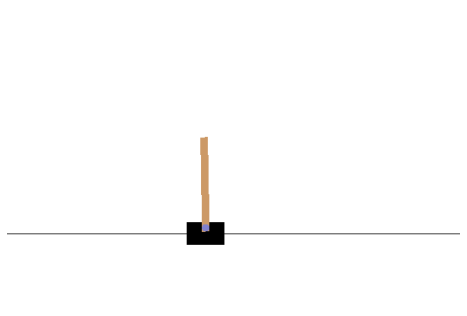

In [48]:
cartpole_env = Environment()
anim = cartpole_env.run()

In [23]:
# きれいに過学習したログ
cartpole_env = Environment()
anim = cartpole_env.run()

Sequential(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)
0 Episode: Finished after 33 steps：10試行の平均step数 = 3.3
1 Episode: Finished after 26 steps：10試行の平均step数 = 5.9
2 Episode: Finished after 41 steps：10試行の平均step数 = 10.0
3 Episode: Finished after 34 steps：10試行の平均step数 = 13.4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:121: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


4 Episode: Finished after 34 steps：10試行の平均step数 = 16.8
5 Episode: Finished after 52 steps：10試行の平均step数 = 22.0
6 Episode: Finished after 29 steps：10試行の平均step数 = 24.9
7 Episode: Finished after 39 steps：10試行の平均step数 = 28.8
8 Episode: Finished after 26 steps：10試行の平均step数 = 31.4
9 Episode: Finished after 23 steps：10試行の平均step数 = 33.7
10 Episode: Finished after 24 steps：10試行の平均step数 = 32.8
11 Episode: Finished after 22 steps：10試行の平均step数 = 32.4
12 Episode: Finished after 58 steps：10試行の平均step数 = 34.1
13 Episode: Finished after 37 steps：10試行の平均step数 = 34.4
14 Episode: Finished after 15 steps：10試行の平均step数 = 32.5
15 Episode: Finished after 29 steps：10試行の平均step数 = 30.2
16 Episode: Finished after 17 steps：10試行の平均step数 = 29.0
17 Episode: Finished after 12 steps：10試行の平均step数 = 26.3
18 Episode: Finished after 52 steps：10試行の平均step数 = 28.9
19 Episode: Finished after 38 steps：10試行の平均step数 = 30.4
20 Episode: Finished after 34 steps：10試行の平均step数 = 31.4
21 Episode: Finished after 18 steps：10試行の平均step数 = 31.

In [49]:
HTML(anim)